In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, KNNRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
# Function for generating Gaussian samples with a specific correlation and mean.
def generateGaussians(sample_size, corr, means):
    # Assign the means and covariance.
    mean = means
    cov = [[1, corr], [corr, 1]]
    # Create the multvariate normals.
    x = np.random.multivariate_normal(mean, cov, sample_size)
    # Create the outputs with the inputs.
    z = makeOutput(x)
    return x,z

In [3]:
# Function for generating Gaussian samples with a specific correlation and mean.
def makeOutput(x):
    # Return the L1 norm of the input array.
    return np.sum(np.abs(x), axis=1)

In [19]:
# Plot the distributions of the input vectors.
def plot_distributions(x1, x2, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    plt.rcParams['font.size'] = '20'
    
    ax[0].scatter(x1[:,0], x1[:,1], s=50)
    ax[0].scatter(x2[:,0]-7, x2[:,1]-7, s=50)
    ax[1].scatter(x1[:,0], x1[:,1], s=50)
    ax[1].scatter(x2[:,0], x2[:,1], s=50)

    ax[0].set_xlim([-8, 8])
    ax[0].set_ylim([-8, 8])
    ax[1].set_xlim([-8, 8])
    ax[1].set_ylim([-8, 8])
    
    ax[0].set_title('Task 1', fontsize=20)
    ax[1].set_title('Task 2', fontsize=20)

    plt.tight_layout()
    plt.show()

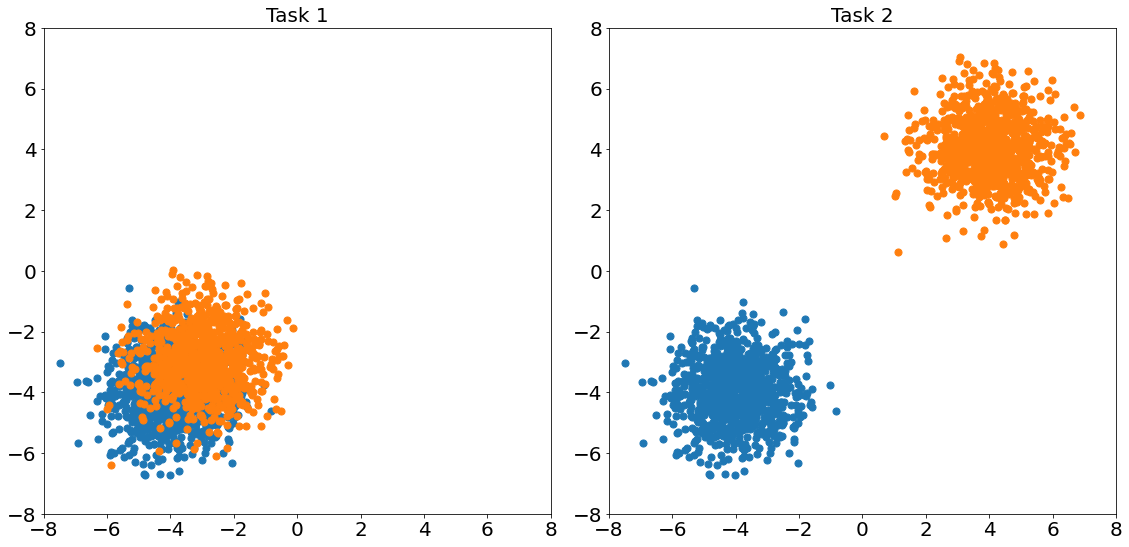

Text(0.5, 0.92, 'Task 2: L1 distance')

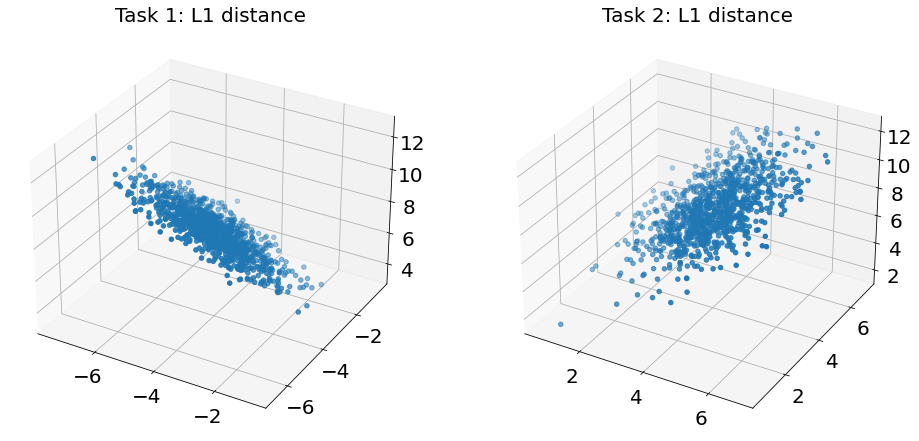

In [20]:
# Creates the means_1, means_2
means_1 = (-4,-4)
means_2 = (4,4)

# Generate Gaussians with the specific samplesize and correlation.
X1, Z1 = generateGaussians((1000), 0, means_1)
X2, Z2 = generateGaussians((1000), 0, means_2)

# Plot the distributions of the 2D data.
plot_distributions(X1, X2, ['Task 1', 'Task 2'])

# Plot the 3D distributions with the z distances.
fig = plt.figure(figsize=(16, 8))
# Add the first task data
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter3D(X1[:,0],X1[:,1], Z1)
ax1.set_title('Task 1: L1 distance', fontsize=20)

# Add the second task data
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter3D(X2[:,0],X2[:,1], Z2)
ax2.set_title('Task 2: L1 distance', fontsize=20)

In [7]:
print(means_2[1:10])

(-4,)


In [8]:
# Set up the tree parameters.
mc_rep = 500
n_test = 1000
n_trees = 10
n_sample_size = 1000
max_depth = 10

# Set up the data parameters.
corr = 0
means_1 = [(4,-4),(4,-3),(4,-2),(4,-1),(4,0),(4,1)]
means_2 = [(4,-4),(4,-3),(4,-2),(4,-1),(4,0),(4,1)]

print(means_1)
print(means_2)

# k_neighbors = [1,3,5,9,17,33]
k_neighbors = [1]

# Set up sample sizes.
samples_task_1 = 1000
samples_task_2 = 1000

[(4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1)]
[(4, -4), (4, -3), (4, -2), (4, -1), (4, 0), (4, 1)]


In [9]:
random_state = 0
np.random.seed(random_state)

# Initiate error arrays
mean_error_fte = np.zeros((len(k_neighbors), 2))
std_error_fte = np.zeros((len(k_neighbors), len(means_2)))

# Initiate transfer efficiency arrays
mean_fte = np.zeros((len(k_neighbors), len(means_2)))

# See if the sample sizes for both training sets are given.
if samples_task_1 == 0 and samples_task_2 == 0:
    raise ValueError("Wake up and provide samples to train!!!")

# If acorn is specified, set random seed to it.
if acorn != None:
    np.random.seed(acorn)

# Initialize array for storing errors, task 1, and task 2.
errors = np.zeros(2, dtype=float)

# Initialize the transformer type and arguments.
default_transformer_class = TreeRegressionTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

# Initialize the voter type and arguments.
default_voter_class = TreeRegressionVoter
default_voter_kwargs = {}

# Initialize the decider type and arguments.
default_decider_class = KNNRegressionDecider
default_decider_kwargs = {"k": k_neighbors}

# Initialize the progressive learner using the transformer, voter and decider classes.
progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class,
                                         default_decider_kwargs = default_decider_kwargs)

# Create the datasets with the Gaussian mean for task 1.
X1,Z1 = generateGaussians(samples_task_1, corr, means_1)
X1_test,Z1_test = generateGaussians(n_test, corr, means_1)

# Add a task for the task 1, predict the probabilities and add the MSE to the error array.
progressive_learner.add_task(X1, Z1,transformer_voter_decider_split=[0.33, 0.33, 0.33])
predicted_Z1 = progressive_learner.predict(X1_test, task_id=0)
errors[0] = mean_squared_error(predicted_Z1, Z1_test)

# Then, add the transformer trained on task 2, predict and add the MSE to the error array.
for i in range(len(means_2)):
    X2,Z2 = generateGaussians(samples_task_2, -corr, means_2[i])
    progressive_learner.add_transformer(X2, Z2)
predicted_transformer_Z1 = progressive_learner.predict(X1_test, task_id=0)
errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)

mean_error_fte = np.mean(error, axis=0)
mean_fte[i,j] = mean_error_fte[0] / mean_error_fte[1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 348 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:   19.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   19.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  7

In [10]:
mean_fte

array([[1.        , 3.13328416, 4.56445498, 3.73552204, 3.24394347,
        4.32425593]])

In [11]:
def experiment_FTE_SimpleAvg(samples_task_1, samples_task_2, n_test, n_trees, max_depth,
                             corr, means_1, means_2, acorn=None):
    
    # See if the sample sizes for both training sets are given.
    if samples_task_1 == 0 and samples_task_2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it.
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, task 1, and task 2.
    errors = np.zeros(2)

    # Initialize the transformer type and arguments.
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    # Initialize the voter type and arguments.
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}

    # Initialize the decider type and arguments.
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}

    # Initialize the progressive learner using the transformer, voter and decider classes.
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets with the Gaussian mean for task 1.
    X1,Z1 = generateGaussians(samples_task_1, corr, means_1)
    X1_test,Z1_test = generateGaussians(n_test, corr, means_1)

    # Add a task for the task 1, predict the probabilities and add the MSE to the error array.
    progressive_learner.add_task(X1, Z1,transformer_voter_decider_split=[0.33, 0.33, 0.33])
    predicted_Z1 = progressive_learner.predict(X1_test, task_id=0)
    errors[0] = mean_squared_error(predicted_Z1, Z1_test)

    # Then, add the transformer trained on task 2, predict and add the MSE to the error array.
    for i in range(len(means_2)):
        X2,Z2 = generateGaussians(samples_task_2, -corr, means_2[i])
        progressive_learner.add_transformer(X2, Z2)
    predicted_transformer_Z1 = progressive_learner.predict(X1_test, task_id=0)
    errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)

    return errors

In [12]:
# Initiate error arrays
mean_error_fte_SimpleAvg = np.zeros((1, len(means_2)))
std_error_fte_SimpleAvg = np.zeros((1, len(means_2)))

# Initiate transfer efficiency arrays
mean_fte_SimpleAvg = np.zeros((1, len(means_2)))

# Create the error.
for i in range(len(means_1)):
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment_FTE_SimpleAvg)(
                samples_task_1, samples_task_2, n_test, n_trees,
                max_depth, corr, means_1[i], means_2[0:i]) for _ in range(mc_rep)
            )
        )
    mean_error_fte_SimpleAvg = np.mean(error, axis=0)
    mean_fte_SimpleAvg[0,i] = mean_error_fte_SimpleAvg[0] / mean_error_fte_SimpleAvg[1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 493 out of 500 | elapsed:   15.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 37

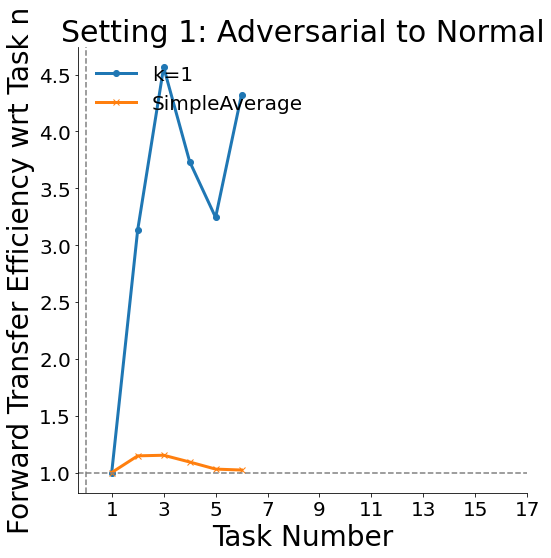

In [13]:
# Create a range of task numbers.
ran = np.arange((mean_fte).shape[1])+1
# labels = ['k=1', 'k=3','k=5','k=9','k=17','k=33', 'SimpleAverage']
labels = ['k=1', 'SimpleAverage']

# Plot the BTEs
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ran, mean_fte[0][0:], ls="-", lw=3, marker='o')
# ax.plot(ran, mean_fte[1][1:], ls="-", lw=3, marker='o')
# ax.plot(ran, mean_fte[2][1:], ls="-", lw=3, marker='o')
# ax.plot(ran, mean_fte[3][1:], ls="-", lw=3, marker='o')
# ax.plot(ran, mean_fte[4][1:], ls="-", lw=3, marker='o')
# ax.plot(ran, mean_fte[5][1:], ls="-", lw=3, marker='o')

ax.plot(ran, mean_fte_SimpleAvg[0][0:], ls="-", lw=3, marker='x')

ax.set_ylabel("Forward Transfer Efficiency wrt Task n", fontsize=28)
ax.legend(labels, loc="upper left", fontsize=20, frameon=False)
ax.set_xlabel("Task Number", fontsize=28)
ax.axvline(x=0, c="gray", linewidth=1.5, linestyle="dashed")
ax.axhline(y=1, c="gray", linewidth=1.5, linestyle="dashed")
ax.set_xticks(np.arange(1, 18, 2))
ax.set_title('Setting 1: Adversarial to Normal', fontsize=30)
ax.tick_params(labelsize=20)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()

In [14]:
ran

array([1, 2, 3, 4, 5, 6])

In [15]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

np.random.seed(0)
test_mean = (-4, -4)
samples = 1000
corr = 0
X1,Z1 = generateGaussians(samples, corr, test_mean)
X1_test,Z1_test = generateGaussians(samples, corr, test_mean)

transformer = DecisionTreeRegressor(max_depth=10).fit(X1, Z1)

X2 = X1_test
transformer.apply(X2)

array([  18,  646,  234,  178, 1010,  650, 1009,  694,  885,  252,  261,
        526,  211,  523,  780,  860, 1023,  952,  532, 1079,  318,  349,
        803,  503,  283,  277,  417,  810,  169,  834,  978,  613,  290,
        470,  504,  943,  856,  881,  433, 1100,  806,  147,  639,  497,
        629,  923,  780,  613,  667, 1027,  813,  689, 1122,  860,  220,
       1112,  133,   11,  532,  413,  943,  198,  319,  391,  433,  345,
        758,  221, 1020,  226,  433,  345,    9,  520,  650,  318,  465,
        593,  151,  109,  174,  494,  646,  211,  443, 1066,  653, 1032,
        731,  526,   52,   38,  496,  211,  318, 1023,  659,  494,  550,
        319,  177,  912,  892,  670,  432,  510,  345,   84,  957,  373,
        754,  721,  414,  748,  154,  745,  465,  329,  817,  407,  281,
       1098,   30,  433,  239, 1024,  445,   11,  228,  998,  699,  316,
        281,  198,  802,  783, 1005, 1006,  534,  702,  318,  138,  694,
        353,  780,  441,  796,  977,  746,   58,  2